***DATA PREP***

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Langkah 1: Memuat Dataset
url = "https://raw.githubusercontent.com/Khalis189/Data-Analyst-Journey_ForecastingSales/refs/heads/main/SuperStore%20-%20data.csv"
df = pd.read_csv(url)

# Langkah 2: Memeriksa Struktur Data
print("Struktur Data:")
display(df.head())



Struktur Data:


,Order_ID,Customer_ID,Postal_Code,Product_ID,Sales,Quantity,Discount,Profit,Category,Sub-Category,Product_Name,Order_Date,Ship_Date,Ship_Mode,Customer_Name,Segment,Country/Region,City,State,Region
0,CA-2019-152156,CG-12520,42420,FUR-BO-10001798,261.9600,2,0.00,41.9136,Furniture,Bookcases,Bush Somerset Collection Bookcase,11/8/2019,11/11/2019,Second Class,Claire Gute,Consumer,United States,Henderson,Kentucky,South
1,CA-2019-152156,CG-12520,42420,FUR-CH-10000454,731.9400,3,0.00,219.5820,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",11/8/2019,11/11/2019,Second Class,Claire Gute,Consumer,United States,Henderson,Kentucky,South
2,CA-2019-138688,DV-13045,90036,OFF-LA-10000240,14.6200,2,0.00,6.8714,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,6/12/2019,6/16/2019,Second Class,Darrin Van Huff,Corporate,United States,Los Angeles,California,West
3,US-2018-108966,SO-20335,33311,FUR-TA-10000577,957.5775,5,0.45,-383.0310,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,10/11/2018,10/18/2018,Standard Class,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,South
4,US-2018-108966,SO-20335,33311,OFF-ST-10000760,22.3680,2,0.20,2.5164,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,10/11/2018,10/18/2018,Standard Class,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,South


In [10]:
# Langkah 3: Memeriksa Nilai yang Hilang
print("\nNilai yang Hilang:")
display(df.isnull().sum())

# Langkah 4: Memeriksa Duplikasi Data
print("\nDuplikasi Data:")
print(df.duplicated().sum())
df =df.drop_duplicates()
print(df.duplicated().sum())


Nilai yang Hilang:


Order_ID          0
Customer_ID       0
Postal_Code       0
Product_ID        0
Sales             0
Quantity          0
Discount          0
Profit            0
Category          0
Sub-Category      0
Product_Name      0
Order_Date        0
Ship_Date         0
Ship_Mode         0
Customer_Name     0
Segment           0
Country/Region    0
City              0
State             0
Region            0
dtype: int64


Duplikasi Data:
1
0


In [11]:
# Langkah 5: Mengonversi Tipe Data
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Ship_Date'] = pd.to_datetime(df['Ship_Date'])

print("\nData setelah preprocessing:")
display(df.head())


Data setelah preprocessing:


,Order_ID,Customer_ID,Postal_Code,Product_ID,Sales,Quantity,Discount,Profit,Category,Sub-Category,Product_Name,Order_Date,Ship_Date,Ship_Mode,Customer_Name,Segment,Country/Region,City,State,Region
0,CA-2019-152156,CG-12520,42420,FUR-BO-10001798,261.9600,2,0.00,41.9136,Furniture,Bookcases,Bush Somerset Collection Bookcase,2019-11-08,2019-11-11,Second Class,Claire Gute,Consumer,United States,Henderson,Kentucky,South
1,CA-2019-152156,CG-12520,42420,FUR-CH-10000454,731.9400,3,0.00,219.5820,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",2019-11-08,2019-11-11,Second Class,Claire Gute,Consumer,United States,Henderson,Kentucky,South
2,CA-2019-138688,DV-13045,90036,OFF-LA-10000240,14.6200,2,0.00,6.8714,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,2019-06-12,2019-06-16,Second Class,Darrin Van Huff,Corporate,United States,Los Angeles,California,West
3,US-2018-108966,SO-20335,33311,FUR-TA-10000577,957.5775,5,0.45,-383.0310,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,2018-10-11,2018-10-18,Standard Class,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,South
4,US-2018-108966,SO-20335,33311,OFF-ST-10000760,22.3680,2,0.20,2.5164,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,2018-10-11,2018-10-18,Standard Class,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,South


***EXPLORATORY DATA***

***1. Deskripsi Data***
**Deskripsi Dataset**
Dataset yang digunakan dalam analisis ini adalah data penjualan dari sebuah perusahaan retail yang mencakup periode waktu dari tahun 2017 hingga 2019. Dataset ini berisi informasi tentang pesanan, pelanggan, produk, dan pengiriman.

**Struktur Dataset**
Berikut adalah kolom-kolom yang terdapat dalam dataset beserta deskripsinya:

| Kolom         | Deskripsi                              |
|---------------|----------------------------------------|
| Order_ID      | ID unik untuk setiap pesanan           |
| Customer_ID   | ID unik untuk setiap pelanggan         |
| Order_Date    | Tanggal pesanan dibuat                 |
| Sales         | Nilai penjualan untuk setiap pesanan   |
| Quantity      | Jumlah barang yang dipesan             |
| Profit        | Keuntungan dari setiap pesanan         |
| Category      | Kategori produk                        |
| Sub-Category  | Sub-kategori produk                    |
| Product_Name  | Nama produk                            |
| Ship_Mode     | Mode pengiriman                        |
| Region        | Wilayah geografis                      |

In [12]:
# Menghitung total pesanan
total_orders = df['Order_ID'].count()

# Menghitung total penjualan
total_sales = df['Sales'].sum()

# Menghitung rata-rata penjualan per pesanan
average_sales_per_order = df.groupby('Order_ID')['Sales'].sum().mean()

# Menghitung total keuntungan
total_profit = df['Profit'].sum()

# Menampilkan hasil
print(f"Total Pesanan: {total_orders}")
print(f"Total Penjualan: ${total_sales:,.2f}")
print(f"Rata-rata Penjualan per Pesanan: ${average_sales_per_order:,.2f}")
print(f"Total Keuntungan: ${total_profit:,.2f}")

Total Pesanan: 9993
Total Penjualan: $2,296,919.49
Rata-rata Penjualan per Pesanan: $458.56
Total Keuntungan: $286,409.08


**Statistik Deskriptif**
- Total Pesanan: 9,993
- Total Penjualan: $2,296,919
- Rata-rata Penjualan per Pesanan: $458.56
- Total Keuntungan: $286,409

**Visualisasi Data**

C:\Users\HoaxBerries\AppData\Local\Temp\ipykernel_2340\3449693813.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Sales'].resample('M').sum()


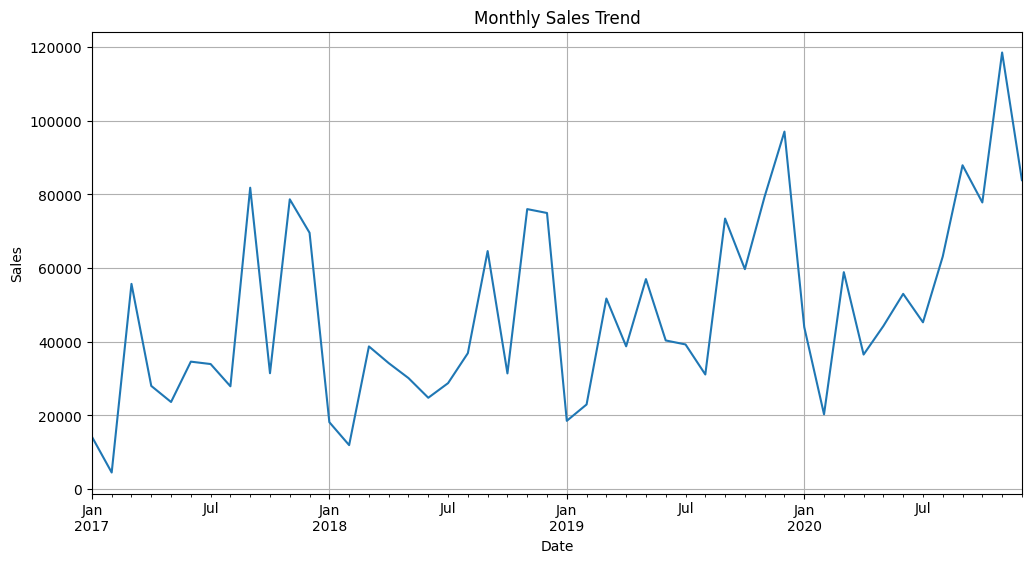

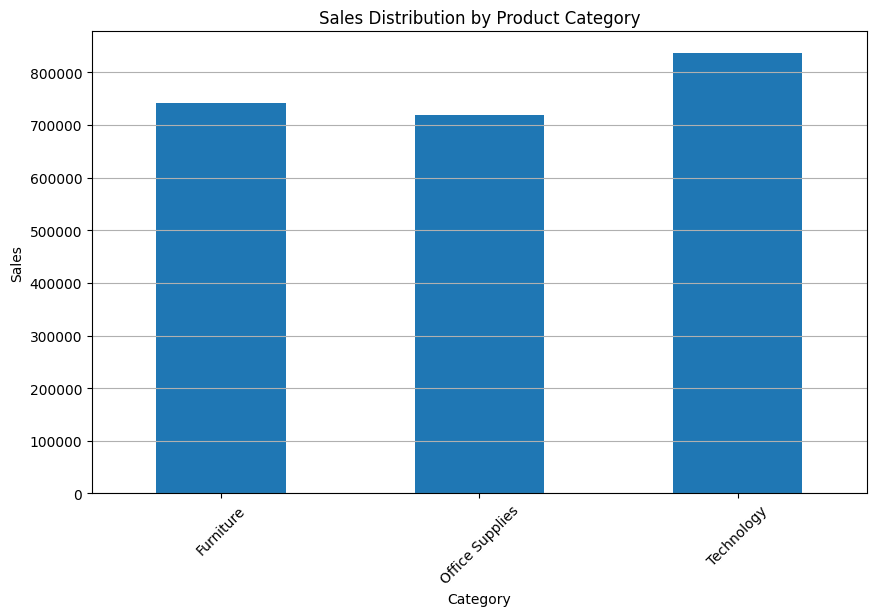

In [13]:
# Mengatur Order_Date sebagai indeks
df.set_index('Order_Date', inplace=True)

# Resample data penjualan per bulan dan plot tren penjualan
monthly_sales = df['Sales'].resample('M').sum()
plt.figure(figsize=(12, 6))
monthly_sales.plot()
plt.title('Monthly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# Plot distribusi penjualan berdasarkan kategori produk
category_sales = df.groupby('Category')['Sales'].sum()
plt.figure(figsize=(10, 6))
category_sales.plot(kind='bar')
plt.title('Sales Distribution by Product Category')
plt.xlabel('Category')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

**Analisis Tren dan Musiman**

**a. Analisis Tren Penjualan**

Kita akan menganalisis tren penjualan untuk mengidentifikasi pola musiman atau siklus dalam data penjualan. Ini bisa dilakukan dengan menggunakan metode dekomposisi waktu.

**b. Dekomposisi Waktu**

Dekomposisi waktu memisahkan data penjualan menjadi tiga komponen: tren, musiman, dan residu. Ini membantu kita memahami bagaimana setiap komponen berkontribusi terhadap data penjualan keseluruhan.

C:\Users\HoaxBerries\AppData\Local\Temp\ipykernel_2340\930441161.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Sales'].resample('M').sum()


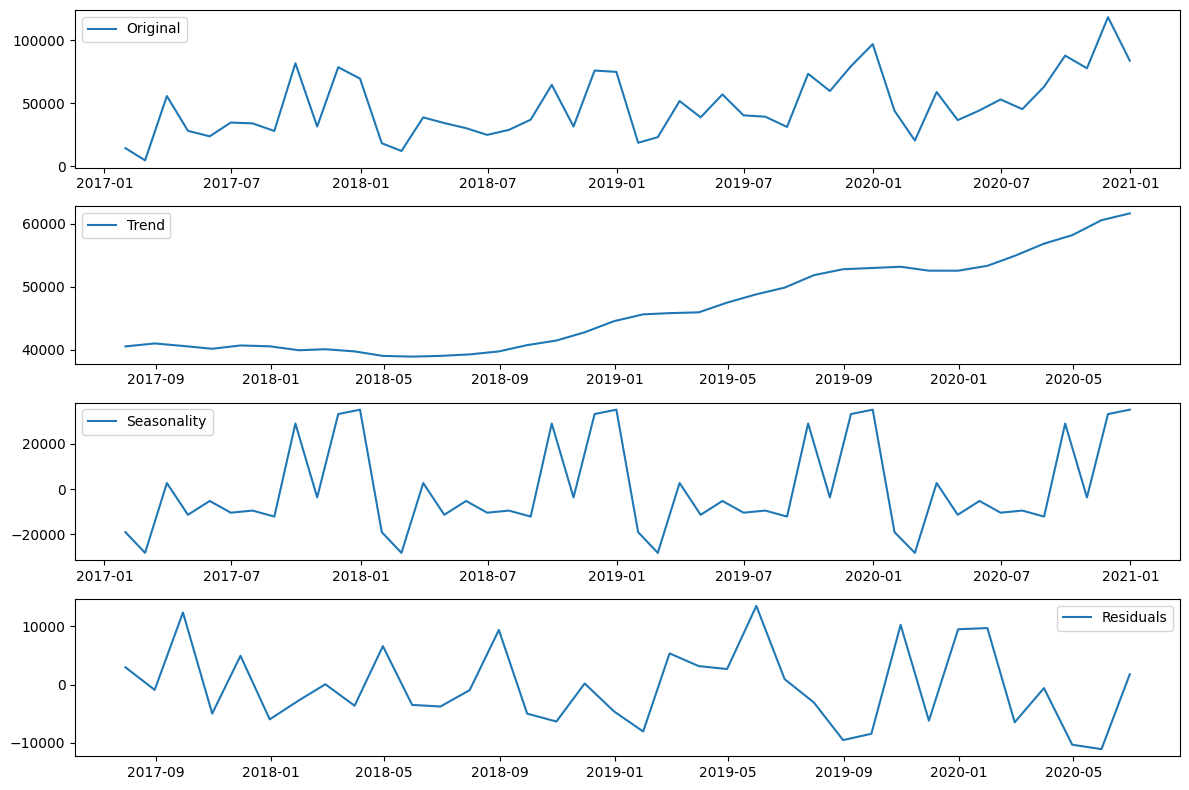

In [14]:
# Resample data penjualan per bulan
monthly_sales = df['Sales'].resample('M').sum()

# Dekomposisi waktu
decomposition = seasonal_decompose(monthly_sales, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot dekomposisi waktu
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(monthly_sales, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**MODEL PREDIKSI**

**ARIMA (AutoRegressive Integrated Moving Average)**



C:\Users\HoaxBerries\AppData\Local\Temp\ipykernel_2340\1839100091.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Sales'].resample('M').sum()


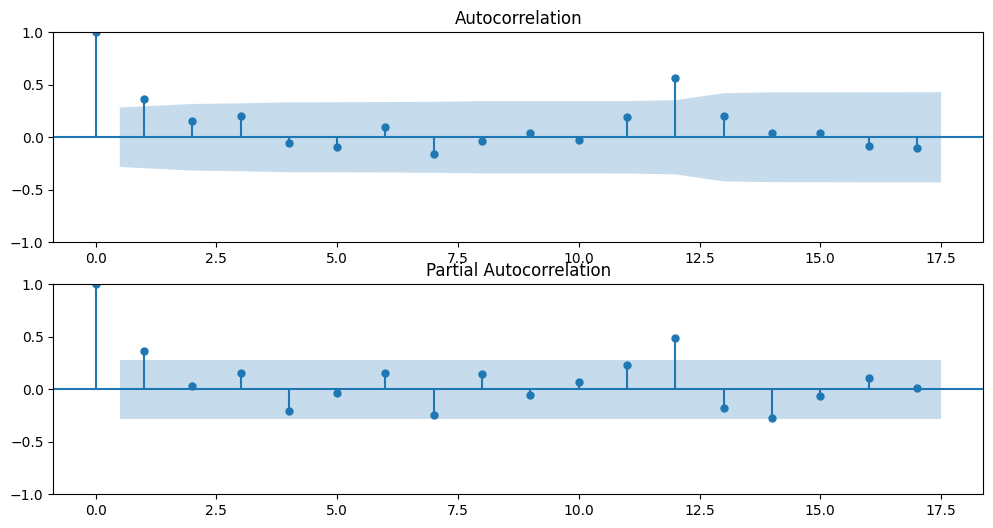

C:\Users\HoaxBerries\AppData\Local\Temp\ipykernel_2340\1839100091.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=monthly_sales.index[-1], periods=12, freq='M')


Mean Absolute Error (MAE): 18422.706827214268
Mean Squared Error (MSE): 564788600.0603327
Root Mean Squared Error (RMSE): 23765.281400823613


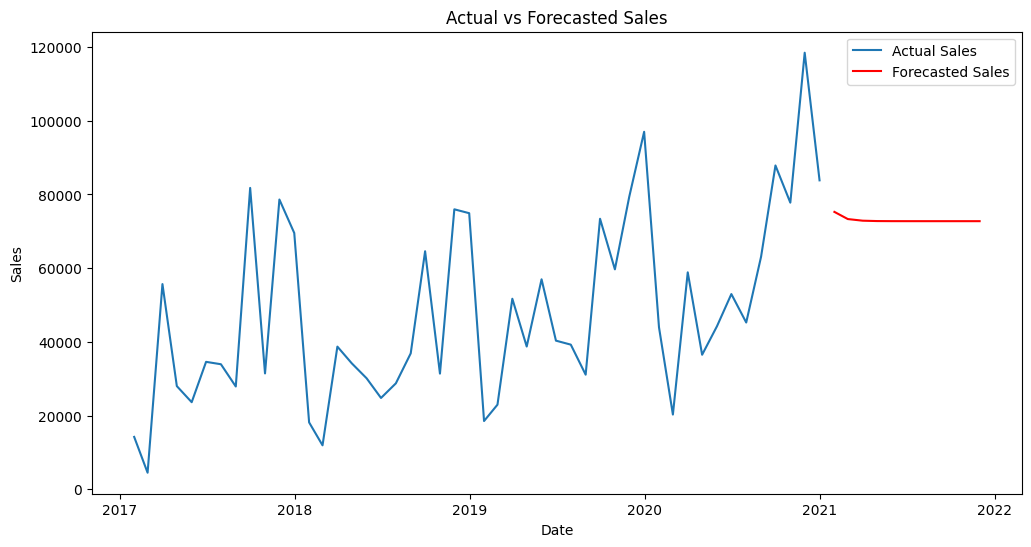

In [15]:
# Resample data penjualan per bulan
monthly_sales = df['Sales'].resample('M').sum()

# Identifikasi parameter ARIMA menggunakan plot ACF dan PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(monthly_sales.dropna(), ax=plt.gca())
plt.subplot(212)
plot_pacf(monthly_sales.dropna(), ax=plt.gca())
plt.show()

# Membangun model ARIMA
model = ARIMA(monthly_sales, order=(1, 1, 1))
model_fit = model.fit()

# Memprediksi penjualan
forecast = model_fit.forecast(steps=12)
forecast_index = pd.date_range(start=monthly_sales.index[-1], periods=12, freq='M')
forecast_series = pd.Series(forecast, index=forecast_index)

# Evaluasi model
y_true = monthly_sales[-12:]
y_pred = model_fit.predict(start=len(monthly_sales)-12, end=len(monthly_sales)-1, typ='levels')

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Actual Sales')
plt.plot(forecast_series, label='Forecasted Sales', color='red')
plt.title('Actual vs Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()